In [1]:
%load_ext autoreload
%autoreload 2
# Set HuggingFace cache directory to scratch to save space.
import os
os.environ['HUGGINGFACE_HUB_CACHE'] = '/scratch/' + os.environ['USER'] + '/huggingface_cache'
CACHE_DIR = '/scratch/' + os.environ['USER'] + '/huggingface_cache'
# Optional; can help when memory is tight.
# os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

### Load HellaSwag Dataset

In [2]:
from datasets import load_dataset
dataset = load_dataset("Rowan/hellaswag", "en-US", split="train", cache_dir=CACHE_DIR)

import numpy as np


selected_indices = np.random.choice(len(dataset["ctx"]), 100, replace=False)
selected_prompts = [dataset["ctx"][i] for i in selected_indices]

selected_prompts

/home/jqm9ba/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['[header] How to buy building insurance [title] Hire a certified professional to evaluate the worth of your building. [step] This person will take outside factors such as location and highway access into consideration when determining the value of your building. [title] Make an inventory of items inside the building that must be insured.',
 'Two young girls are talking to a camera doing a vlog. they',
 '[header] How to do the five tibetan rites [title] Run a minute on tiptoe on the spot, turn in a circle (around your own axis, the spine) and shake your arms. [step] You can turn around the right or left. While circling around, visualize a cloud of light around you and think the word " light " as a mantra.',
 'A man shows a plaid shirt while explaining. then',
 "[header] How to be emo at a school with uniforms [title] Straighten your hair. [step] This is a simple thing you can do that most likely won't be against your school's rules. Emo people typically have super straight hair.",
 'He

In [3]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

model = AutoModelForCausalLM.from_pretrained("microsoft/phi-2", torch_dtype="auto", trust_remote_code=True).to('cuda')
tokenizer = AutoTokenizer.from_pretrained("microsoft/phi-2", trust_remote_code=True)
tokenizer.pad_token_id = tokenizer.eos_token_id

Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  2.20it/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [4]:
from IPython.display import display, HTML, Markdown

def generate(model, tokenizer, prompt, do_display=True, max_new_tokens=50):
    input_string = prompt
    inputs = tokenizer(input_string, return_tensors="pt", return_attention_mask=True).to('cuda')
    
    outputs = model.generate(**inputs, max_new_tokens=max_new_tokens, temperature=0)
    text = tokenizer.batch_decode(outputs)[0][len(input_string):]

    if do_display:
        display(HTML(f"<pre>{input_string}</pre><pre style='background-color: rgb(200, 255, 200, 1.0)'>{text}<pre>"))

    return inputs['input_ids'][0], outputs[0], text

def run_coding_sample(model, tokenizer, display=True):
    prompt = '''def print_prime(n):
       """
       Print all primes between 1 and n
       """'''
    return generate(model, tokenizer, prompt, display)

def run_coding_sample_2(model, tokenizer):
    prompt = '''def array_sum(array, nrows, ncols):
       """
       Use two for loops to add elements of an array.
       """'''
    return generate(model, tokenizer, prompt)

In [5]:
from hooked_phi import attach_hooks, detach_hooks

all_results = []
all_results_tokenized = []

# Returns a hook that can be used to ablate a set of neurons.
def ablate_neurons(mask):
    assert mask.shape[0] == model.config.num_hidden_layers
    assert mask.shape[1] == model.config.intermediate_size

    def hook(neurons, layer_idx):
        neurons[..., ~mask[layer_idx]] = 0
        return neurons

    return hook

# Ablate the last layer MLP.
for num_ablation_layers in range(0, 5, 1):
    display(Markdown(f'# Zeroing-out intermediate layers of the last {num_ablation_layers} MLPs'))
    
    mask = torch.ones((model.config.num_hidden_layers, model.config.intermediate_size), dtype=torch.bool)
    if num_ablation_layers > 0:
        mask[-num_ablation_layers:, :] = False
    
    attach_hooks(model.model, ablate_neurons(mask))
    
    # input_ids, input_and_completion_ids, result = run_coding_sample(model, tokenizer)
    input_ids, input_and_completion_ids, result = generate(model, tokenizer, "Instruct: What is the square root of 2?\n\nOutput:", do_display=True)
    if num_ablation_layers == 0:
        ground_truth = result
    
    all_results.append(result)

detach_hooks(model.model)

# Zeroing-out intermediate layers of the last 0 MLPs

/home/jqm9ba/.conda/envs/nlp-env/lib/python3.8/site-packages/transformers/generation/configuration_utils.py:392: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


# Zeroing-out intermediate layers of the last 1 MLPs

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


# Zeroing-out intermediate layers of the last 2 MLPs

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


# Zeroing-out intermediate layers of the last 3 MLPs

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


# Zeroing-out intermediate layers of the last 4 MLPs

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [6]:
from evaluator import perplexity_evaluator

perplexity_result = perplexity_evaluator(preds=all_results)

Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.41it/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 1/1 [00:00<00:00,  9.43it/s]


# Evaluate with HellaSwag

In [7]:
ground_truths = []
predictions = {}

for prompt in selected_prompts:
    
    # Ablate the last layer MLP.
    for num_ablation_layers in range(0, 32, 3):
        
        mask = torch.ones((model.config.num_hidden_layers, model.config.intermediate_size), dtype=torch.bool)
        if num_ablation_layers > 0:
            mask[-num_ablation_layers:, :] = False
        
        attach_hooks(model.model, ablate_neurons(mask))
        
        input_ids, input_and_completion_ids, result = generate(model, tokenizer, prompt, do_display=False)
        
        if num_ablation_layers == 0:
            ground_truths.append(prompt+result)
        
        if num_ablation_layers not in predictions:
            predictions[num_ablation_layers] = []
        
        predictions[num_ablation_layers].append(prompt+result)
        

    detach_hooks(model.model)

/home/jqm9ba/.conda/envs/nlp-env/lib/python3.8/site-packages/transformers/generation/configuration_utils.py:392: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

In [8]:
import evaluate
from typing import List

results = {}

rouge = evaluate.load("rouge", module_type="metric", cache_dir=CACHE_DIR)
perplexity = evaluate.load("perplexity", module_type="metric", cache_dir=CACHE_DIR)
wer = evaluate.load("wer", module_type="metric", cache_dir=CACHE_DIR)

for key, value in predictions.items():
    rouge_result = rouge.compute(references=ground_truths, predictions=value)
    perplexity_result = perplexity.compute(predictions=value, model_id='microsoft/phi-2')
    wer_result = wer.compute(references=ground_truths, predictions=value)
    
    results[key] = {
        'rouge_result': rouge_result,
        'perplexity_result': perplexity_result,
        'wer_result': wer_result
    }

Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.39it/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.50it/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Loading checkpoint shards: 100%|██████████| 2

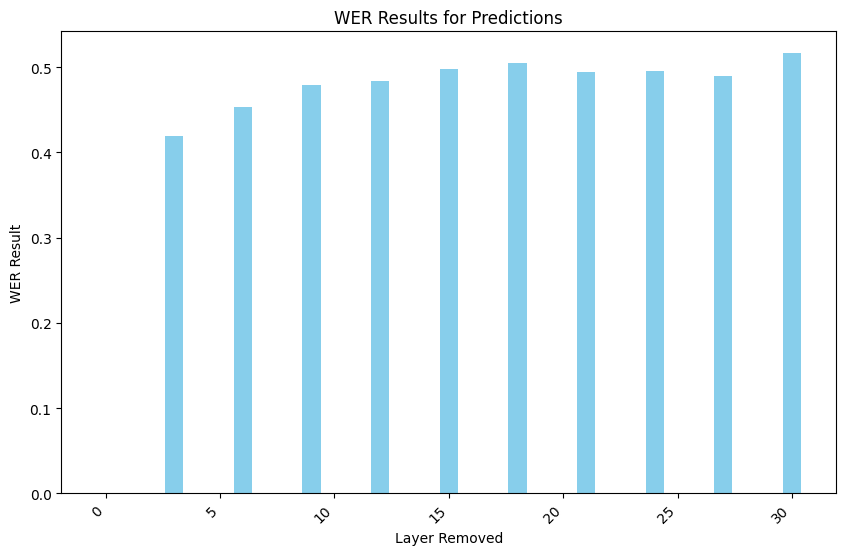

In [11]:
import matplotlib.pyplot as plt

keys = list(results.keys())
wer_results = [results[key]['wer_result'] for key in keys]

# Creating the bar graph
plt.figure(figsize=(10, 6))
plt.bar(keys, wer_results, color='skyblue')

plt.xlabel('Layer Removed')
plt.ylabel('WER Result')
plt.title('WER Results for Predictions')
plt.xticks(rotation=45, ha="right")

plt.show()

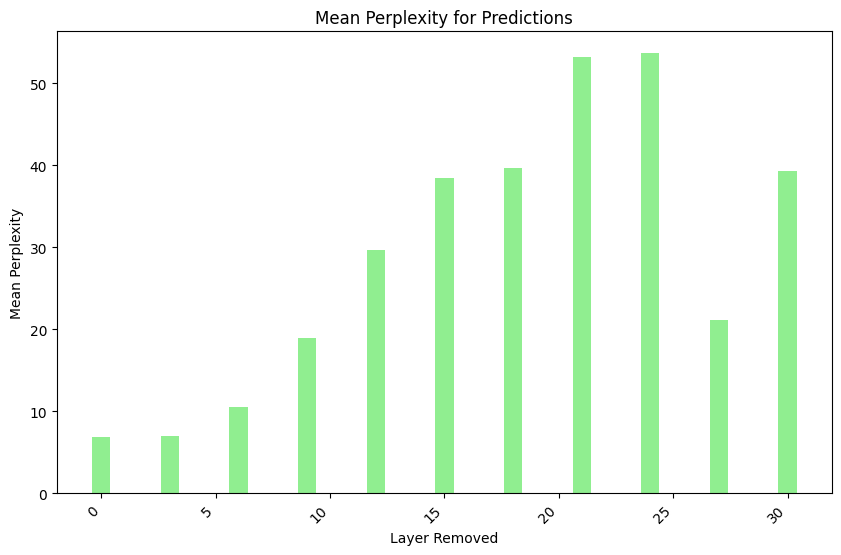

In [13]:
keys = list(results.keys())
mean_perplexities = [results[key]['perplexity_result']['mean_perplexity'] for key in keys]

# Creating the bar graph for mean perplexity
plt.figure(figsize=(10, 6))
plt.bar(keys, mean_perplexities, color='lightgreen')

plt.xlabel('Layer Removed')
plt.ylabel('Mean Perplexity')
plt.title('Mean Perplexity for Predictions')
plt.xticks(rotation=45, ha="right")

plt.show()

In [16]:
# This is called "neuron vis", but can really be used for anything involving a score assigned to each token.
# In this case, visualize logprob
from neuron_visualization import basic_neuron_vis, basic_neuron_vis_signed

# Get granular nll estimates
display(Markdown(f'# Visualizing How Log-Likelihood Evolves, and For Which Tokens'))

# 1. Get ground truth.
detach_hooks(model.model)
input_ids, input_and_completion_ids, ground_truth = generate(model, tokenizer, "Instruct: What is 1 + 234?\n\nOutput: 1 + 234 =", do_display=False, max_new_tokens=3)
completion_ids = input_and_completion_ids[len(input_ids):]

# Calculate baseline logprobs.
predictions_for_next_token = model(input_ids=input_and_completion_ids.unsqueeze(0))
logits = predictions_for_next_token[0][0]
logits_for_output_tokens = logits[len(input_ids) - 1:-1]
logprobs_for_output_tokens = torch.log_softmax(logits_for_output_tokens, dim=-1)
baseline_logprobs_for_sampled_output_tokens = logprobs_for_output_tokens[
    torch.arange(logprobs_for_output_tokens.shape[0]),
    completion_ids
]

# 2. Ablate model. See which suddens suddenly become highly unlikely (by visualizing negative logprobs).
# for ablation_layer in range(31, 31 - 8 - 1, -1):
for ablation_layer in range(31, -1, -1):
    mask = torch.ones((model.config.num_hidden_layers, model.config.intermediate_size), dtype=torch.bool)
    
    display(Markdown(f'## Ablating MLP {ablation_layer + 1} / 32'))
    mask[ablation_layer, :] = False

# for num_ablation_layers in range(0, 5, 1):
    # mask = torch.ones((model.config.num_hidden_layers, model.config.intermediate_size), dtype=torch.bool)
    # if num_ablation_layers == 0:
    #     display(Markdown(f'## Baseline'))
    # else:
    #     display(Markdown(f'## Ablating final {num_ablation_layers} MLPs'))
    # if num_ablation_layers > 0:
    #     mask[-num_ablation_layers:, :] = False

    attach_hooks(model.model, ablate_neurons(mask))
    predictions_for_next_token = model(input_ids=input_and_completion_ids.unsqueeze(0))
    logits = predictions_for_next_token[0][0]
    logits_for_output_tokens = logits[len(input_ids) - 1:-1]
    logprobs_for_output_tokens = torch.log_softmax(logits_for_output_tokens, dim=-1)
    logprobs_for_sampled_output_tokens = logprobs_for_output_tokens[
        torch.arange(logprobs_for_output_tokens.shape[0]),
        completion_ids
    ]

    # visualized_tokens = outputs[0].cpu()[len(inputs['input_ids'][0].cpu()):]
    visualized_tokens = input_and_completion_ids.cpu()
    token_names = [
        tokenizer.decode(torch.tensor([visualized_tokens[i]]))
        for i in range(len(visualized_tokens))
    ]

    deflections = logprobs_for_sampled_output_tokens - baseline_logprobs_for_sampled_output_tokens

    colors = torch.cat([torch.zeros_like(input_ids), deflections])

    print("Average deflection:", deflections.mean().item())
    print("Worst deflection:", deflections.min().item())
    html = basic_neuron_vis_signed(token_names, colors, 1)
    display(HTML(html))

detach_hooks(model.model)



# Visualizing How Log-Likelihood Evolves, and For Which Tokens

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


## Ablating MLP 32 / 32

Average deflection: 0.07768365740776062
Worst deflection: 0.0336986780166626


## Ablating MLP 31 / 32

Average deflection: -0.16328978538513184
Worst deflection: -0.2753016948699951


## Ablating MLP 30 / 32

Average deflection: -0.01605325937271118
Worst deflection: -0.030004426836967468


## Ablating MLP 29 / 32

Average deflection: -0.027332646772265434
Worst deflection: -0.10021320730447769


## Ablating MLP 28 / 32

Average deflection: -0.02445281855762005
Worst deflection: -0.035516709089279175


## Ablating MLP 27 / 32

Average deflection: -0.05928967893123627
Worst deflection: -0.17928975820541382


## Ablating MLP 26 / 32

Average deflection: -0.035049185156822205
Worst deflection: -0.08637324720621109


## Ablating MLP 25 / 32

Average deflection: -0.0681414008140564
Worst deflection: -0.2265840768814087


## Ablating MLP 24 / 32

Average deflection: -0.036493390798568726
Worst deflection: -0.053367577493190765


## Ablating MLP 23 / 32

Average deflection: -0.02271135523915291
Worst deflection: -0.09711600095033646


## Ablating MLP 22 / 32

Average deflection: -0.15600799024105072
Worst deflection: -0.47297778725624084


## Ablating MLP 21 / 32

Average deflection: 0.022839127108454704
Worst deflection: -0.002008497714996338


## Ablating MLP 20 / 32

Average deflection: 0.03132982552051544
Worst deflection: 0.008688375353813171


## Ablating MLP 19 / 32

Average deflection: -0.06590586155653
Worst deflection: -0.17163318395614624


## Ablating MLP 18 / 32

Average deflection: 0.025586340576410294
Worst deflection: 0.020445644855499268


## Ablating MLP 17 / 32

Average deflection: 0.005048148334026337
Worst deflection: -0.016864530742168427


## Ablating MLP 16 / 32

Average deflection: -0.06899186968803406
Worst deflection: -0.15759199857711792


## Ablating MLP 15 / 32

Average deflection: -0.05841604992747307
Worst deflection: -0.1488637626171112


## Ablating MLP 14 / 32

Average deflection: -0.021835900843143463
Worst deflection: -0.057647861540317535


## Ablating MLP 13 / 32

Average deflection: -0.008968241512775421
Worst deflection: -0.03584178537130356


## Ablating MLP 12 / 32

Average deflection: -0.04161371290683746
Worst deflection: -0.07598749548196793


## Ablating MLP 11 / 32

Average deflection: -0.020339228212833405
Worst deflection: -0.039547473192214966


## Ablating MLP 10 / 32

Average deflection: 0.006217678543180227
Worst deflection: -0.06522640585899353


## Ablating MLP 9 / 32

Average deflection: -0.11548216640949249
Worst deflection: -0.4787823259830475


## Ablating MLP 8 / 32

Average deflection: -0.06585612148046494
Worst deflection: -0.2753565013408661


## Ablating MLP 7 / 32

Average deflection: -0.01864797994494438
Worst deflection: -0.07712939381599426


## Ablating MLP 6 / 32

Average deflection: 0.022339878603816032
Worst deflection: -0.04454684257507324


## Ablating MLP 5 / 32

Average deflection: -0.23974506556987762
Worst deflection: -0.9196645021438599


## Ablating MLP 4 / 32

Average deflection: 0.02550864964723587
Worst deflection: -0.0015297085046768188


## Ablating MLP 3 / 32

Average deflection: -0.030983038246631622
Worst deflection: -0.05739569664001465


## Ablating MLP 2 / 32

Average deflection: -0.07406484335660934
Worst deflection: -0.1627112329006195


## Ablating MLP 1 / 32

Average deflection: -5.8217973709106445
Worst deflection: -17.025623321533203


# Viewing "kernel" of MLP intermediate states

If there MLP intermediate states represent recall coefficients - with the MLP encoder representing detection, and the MLP decoder representing triggering of the new memory - we would expect that most MLP intermediate states would be 0 (as only a sparse number of "memories" should be activated at any given time), or that MLP intermediate states would be correlated with meaningful concepts. Let's test this hypothesis.

In [ ]:
def log_neurons(neurons, layer_idx):
    if layer_idx == 0:
        log.append([])

    log[-1].append(neurons)
    
    return neurons

attach_hooks(model.model, log_neurons)

In [ ]:
log = []
inputs, outputs, text = run_coding_sample_2(model, tokenizer)

layer_id = 0

all_mlp_activations = []
for i in range(len(log)):
    # log[forward pass index][layer index][batch index, token index in forward pass, mlp neuron index]
    mlp_activations = log[i][layer_id][0, -1, :]
    all_mlp_activations.append(mlp_activations)

stacked = torch.stack(all_mlp_activations, dim=0)

# Scale each MLP intermediate neuron by the maximum absolute value
scale_by_dim = torch.max(stacked.abs(), dim=0, keepdims=True).values
stacked_scaled = stacked / (scale_by_dim + 1e-5)


In [ ]:
import matplotlib.pyplot as plt

plt.title("MLP activations: Last Layer (Unscaled)")
plt.hist(stacked.view(-1).cpu(), bins=25)
plt.xlabel("MLP activation level")
plt.yscale("log")
plt.ylabel("Frequency")
plt.show()

plt.title("MLP activations: Last Layer (Scaled per dim.)")
plt.hist(stacked_scaled.view(-1).cpu(), bins=25)
plt.xlabel("MLP activation level")
plt.yscale("log")
plt.ylabel("Frequency")
plt.show()

## Interpretation

It seems that MLP activations are very sparse. Therefore, it will hopefully be relatively simple to find meaningful MLP neurons to visualize.

To automatically determine which MLP activations are most interesting, I will calculate the variance of the activations.


In [ ]:
from neuron_visualization import basic_neuron_vis

variance = stacked.var(dim=0)
highest_to_lowest_variance = variance.argsort(descending=True)
visualized_tokens = outputs[0].cpu()[len(inputs['input_ids'][0].cpu()):]

token_names = [
    tokenizer.decode(torch.tensor([visualized_tokens[i]]))
    for i in range(len(visualized_tokens))
]

visualized_neurons = highest_to_lowest_variance[:100]

for neuron_i in range(len(visualized_neurons)):
    neuron_id = visualized_neurons[neuron_i]
    html = basic_neuron_vis(token_names, stacked[:, neuron_id], layer=layer_id, neuron_index=neuron_id)
    display(HTML(html))
